# Feature Engineering

In [138]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

df = pd.read_csv("../data/merged_data.csv", parse_dates=["datetime"])
df = df.sort_values("datetime")
df["hour"] = df["datetime"].dt.hour
df["is_daytime"] = ((df["hour"] >= 7) & (df["hour"] < 19)).astype(int)

df = df.drop(columns=["hour"])

df["sin_hour"] = np.sin(2 * np.pi * df["datetime"].dt.hour / 24)
df["cos_hour"] = np.cos(2 * np.pi * df["datetime"].dt.hour / 24)
df["price_lag_1h"] = df["price_EUR_MWh"].shift(1)

df = df.dropna()

# features = [
#     "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation",
#     "quantity_biomass", "quantity_fossil_gas", "quantity_fossil_hard_coal",
#     "quantity_hydro_run_of_river", "quantity_nuclear", "quantity_solar",
#     "quantity_waste", "quantity_wind_offshore", "quantity_wind_onshore",
#     "quantity_other", "price_lag_1h", "is_daytime", "sin_hour", "cos_hour", "quantity_MW"
# ]

features = [
    "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation", "quantity_solar",
    "quantity_other", "price_lag_1h", "is_daytime", "sin_hour", "cos_hour", "quantity_MW"
]
target = "price_EUR_MWh"

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = scaler_x.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

# # Splitting indices before scaling
# val_days = 30
# val_size = val_days * 24

# train_df = df.iloc[:-val_size]
# val_df = df.iloc[-val_size:]

# # Fit scalers ONLY on training data
# scaler_x = StandardScaler()
# scaler_y = StandardScaler()

# scaler_x.fit(train_df[features])
# scaler_y.fit(train_df[[target]])

# # Transform entire dataset safely
# X = scaler_x.transform(df[features])
# y = scaler_y.transform(df[[target]])


# Model

In [139]:
class TimeSeriesDataset(Dataset):
    """
    Custom Dataset for time series data with fixed sequence length.
    """
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_len],
            self.y[idx+self.seq_len]
        )

class DSSM(nn.Module):
    """
    Deep Structured State Model (DSSM) for time series forecasting.
    This model uses a GRU for state representation and a feedforward network for observation modeling.
    """
    def __init__(self, input_dim, state_dim, hidden_dim):
        super().__init__()
        self.rnn = nn.GRU(input_dim, state_dim, batch_first=True, num_layers=3, dropout=0.1)
        self.obs_model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        state_seq, _ = self.rnn(x)
        output = self.obs_model(state_seq[:, -1, :])
        return output.squeeze(-1)

In [140]:
# Splitting the dataset into training and validation sets
# Assuming the data is hourly and we want to validate on the last 30 days
sequence_length = 168
val_days = 30
val_size = val_days * 24

train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]
val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model, optimizer, and loss function
model = DSSM(input_dim=X.shape[1], state_dim=64, hidden_dim=128)
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.L1Loss()
# criterion = nn.HuberLoss()
# criterion = nn.SmoothL1Loss()

# Training the model
n_epochs = 30
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for x, t in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, t.squeeze(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, t in val_loader:
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            val_loss += loss.item()
    model.train()

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1, Train Loss: 0.3909, Val Loss: 0.2474
Epoch 2, Train Loss: 0.3425, Val Loss: 0.1942
Epoch 3, Train Loss: 0.3004, Val Loss: 0.1688
Epoch 4, Train Loss: 0.2659, Val Loss: 0.1654
Epoch 5, Train Loss: 0.2263, Val Loss: 0.1554
Epoch 6, Train Loss: 0.2051, Val Loss: 0.1537
Epoch 7, Train Loss: 0.2379, Val Loss: 0.1489
Epoch 8, Train Loss: 0.2064, Val Loss: 0.1401
Epoch 9, Train Loss: 0.1995, Val Loss: 0.1419
Epoch 10, Train Loss: 0.1983, Val Loss: 0.1415
Epoch 11, Train Loss: 0.1957, Val Loss: 0.1371
Epoch 12, Train Loss: 0.1830, Val Loss: 0.1342
Epoch 13, Train Loss: 0.1800, Val Loss: 0.1333
Epoch 14, Train Loss: 0.1931, Val Loss: 0.1362
Epoch 15, Train Loss: 0.1775, Val Loss: 0.1342
Epoch 16, Train Loss: 0.1922, Val Loss: 0.1383
Epoch 17, Train Loss: 0.2082, Val Loss: 0.1348
Epoch 18, Train Loss: 0.1807, Val Loss: 0.1302
Epoch 19, Train Loss: 0.1750, Val Loss: 0.1285
Epoch 20, Train Loss: 0.1820, Val Loss: 0.1273
Epoch 21, Train Loss: 0.1757, Val Loss: 0.1315
Epoch 22, Train Loss: 

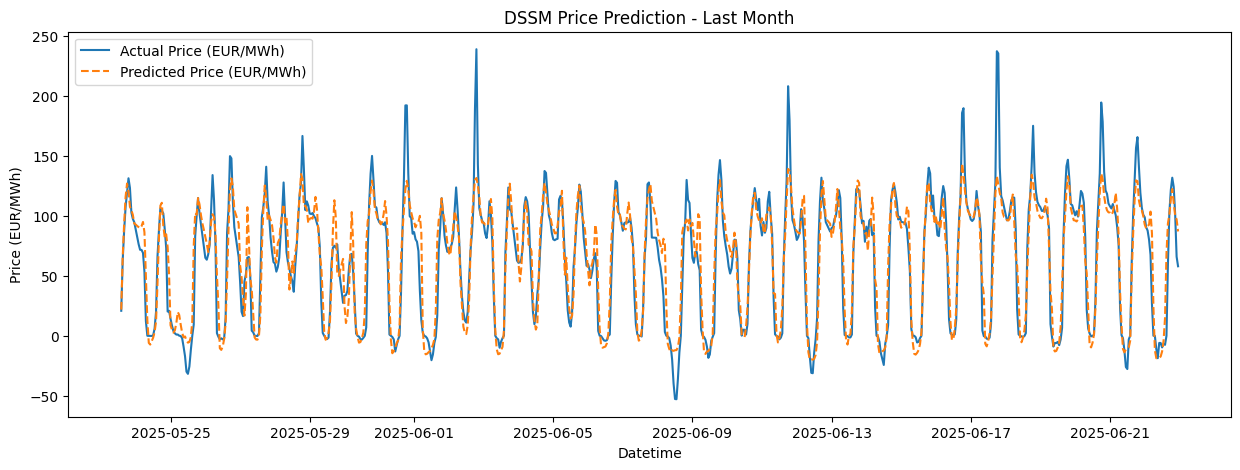

In [143]:
# Evaluation on the last month
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for x, t in val_loader:
        preds = model(x)
        all_preds.append(preds.numpy())
        all_actuals.append(t.squeeze(-1).numpy())

preds_flat = np.concatenate(all_preds)
actuals_flat = np.concatenate(all_actuals)

preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()
actuals_inverse = scaler_y.inverse_transform(actuals_flat.reshape(-1, 1)).flatten()

# Plotting the results for the last month
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 5))
plt.plot(val_datetimes, actuals_inverse, label="Actual Price (EUR/MWh)")
plt.plot(val_datetimes, preds_inverse, label="Predicted Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Prediction - Last Month")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()

In [ ]:
threshold = np.std(actuals_inverse)
errors = np.abs(actuals_inverse - preds_inverse)
accuracy_within_threshold = np.mean(errors < threshold) * 100

print(f"Threshold Accuracy (< {threshold} EUR/MWh): {accuracy_within_threshold:.2f}%")

Threshold Accuracy (< 52.11871337890625 EUR/MWh): 97.50%


In [149]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actuals_inverse, preds_inverse)
mae = mean_absolute_error(actuals_inverse, preds_inverse)

denom = (np.abs(actuals_inverse) + np.abs(preds_inverse)) / 2
non_zero_mask = denom != 0
smape = np.mean(np.abs(actuals_inverse - preds_inverse)[non_zero_mask] / denom[non_zero_mask]) * 100

print(f"Validation Set Metrics:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"SMAPE: {smape:.2f}%")
print(f"Threshold Accuracy: {accuracy_within_threshold:.2f}%")


Validation Set Metrics:
MSE: 373.24
MAE: 13.32
SMAPE: 51.28%
Threshold Accuracy: 97.50%


In [150]:
block_size = 6
total_blocks = 28

# Results per block
block_metrics = []

for i in range(total_blocks):
    start = i * block_size
    end = (i + 1) * block_size

    block_actuals = actuals_inverse[start:end]
    block_preds = preds_inverse[start:end]

    mse = mean_squared_error(block_actuals, block_preds)
    mae = mean_absolute_error(block_actuals, block_preds)

    errors = np.abs(block_actuals - block_preds)
    accuracy_within_threshold = np.mean(errors < threshold) * 100

    denom = (np.abs(block_actuals) + np.abs(block_preds)) / 2
    non_zero_mask = denom != 0
    smape = np.mean(np.abs(block_actuals - block_preds)[non_zero_mask] / denom[non_zero_mask]) * 100

    block_metrics.append({
        "Block": i + 1,
        "Start Hour": start,
        "End Hour": end,
        "MSE": mse,
        "MAE": mae,
        "SMAPE": smape,
        "Accuracy within Threshold": accuracy_within_threshold
    })

block_df = pd.DataFrame(block_metrics)

print("\nPer Block Metrics:")
print(block_df.round(2))

# Group into Horizon Tiers
tiers = {
    "Short-term (0–24h)": block_df.iloc[0:4],
    "Medium-term (24–72h)": block_df.iloc[4:12],
    "Long-term (72–168h)": block_df.iloc[12:28]
}

print("\nAggregated Metrics by Horizon Tier:")
for tier_name, tier_df in tiers.items():
    mse_mean = tier_df["MSE"].mean()
    mae_mean = tier_df["MAE"].mean()
    smape_mean = tier_df["SMAPE"].median()
    print(f"\n{tier_name}")
    print(f"MSE: {mse_mean:.2f}")
    print(f"MAE: {mae_mean:.2f}")
    print(f"SMAPE: {smape_mean:.2f}%")
    print(f"Accuracy within Threshold: {tier_df['Accuracy within Threshold'].mean():.2f}%")


Per Block Metrics:
    Block  Start Hour  End Hour     MSE    MAE       SMAPE  \
0       1           0         6   47.99   6.06    6.280000   
1       2           6        12   60.53   5.89    5.830000   
2       3          12        18  688.09  24.84   44.000000   
3       4          18        24   47.41   5.86  173.309998   
4       5          24        30  128.54   9.35   19.690001   
5       6          30        36  671.60  18.54   53.020000   
6       7          36        42  140.54   9.84  143.589996   
7       8          42        48  356.47  16.93  160.720001   
8       9          48        54  829.20  18.20   90.160004   
9      10          54        60  149.87  11.72   14.430000   
10     11          60        66  238.86  11.41   11.030000   
11     12          66        72  537.09  16.40  126.489998   
12     13          72        78  507.23  19.64   25.840000   
13     14          78        84  510.50  21.47   52.480000   
14     15          84        90  616.51  20.96   6

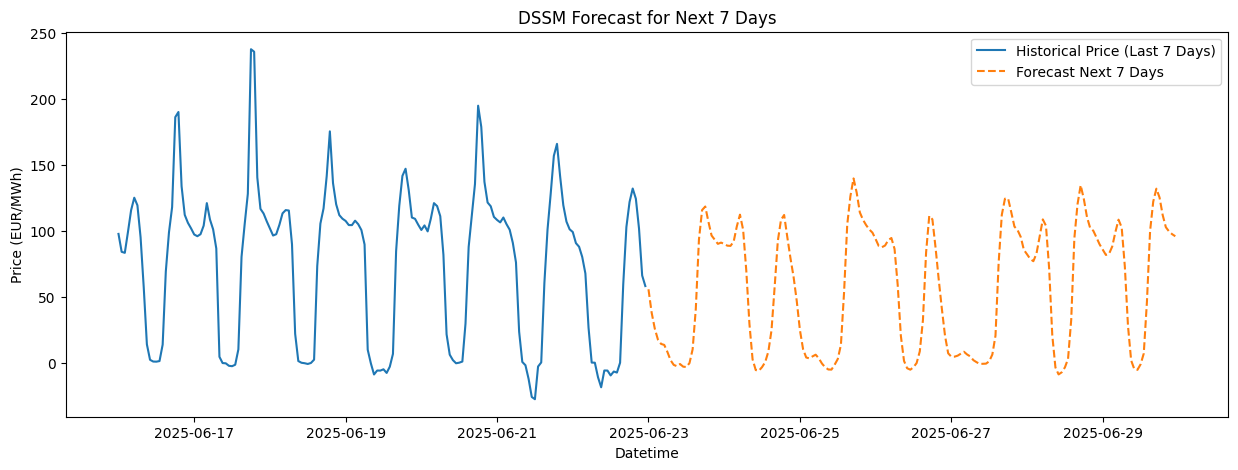

In [100]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

forecast_horizon = 168  # 7 days
# sequence_length = 168

# Load weather forecast
weather_df = pd.read_csv("../data/weather_forecast.csv", parse_dates=["datetime"])
weather_df = weather_df.sort_values("datetime").reset_index(drop=True)

# Optional: Scale weather columns now if your model expects scaled weather inputs
weather_features = ["temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation"]
scaler_weather = StandardScaler()
scaler_weather.fit(df[weather_features])  # Fit only on weather columns
# Scale weather forecast
weather_df[weather_features] = scaler_weather.transform(weather_df[weather_features])

# Prepare latest known features
latest_features = df[features].iloc[-sequence_length:].copy()
latest_scaled = scaler_x.transform(latest_features)

input_seq = torch.tensor(latest_scaled, dtype=torch.float32).unsqueeze(0)
current_seq = input_seq.clone()

forecast_scaled = []
forecast_unscaled = []

for i in range(forecast_horizon):
    model.eval()
    with torch.no_grad():
        pred_scaled = model(current_seq).item()  # Model predicts scaled price
        forecast_scaled.append(pred_scaled)

    pred_unscaled = scaler_y.inverse_transform(np.array([[pred_scaled]]))[0, 0]
    forecast_unscaled.append(pred_unscaled)

    shifted_seq = current_seq[:, 1:, :].squeeze(0).numpy()
    next_feature = shifted_seq[-1].copy()

    # Update lag price feature with scaled prediction (model output already scaled)
    idx_lag = features.index('price_lag_1h')
    next_feature[idx_lag] = pred_scaled

    # Generate new datetime
    new_datetime = df["datetime"].iloc[-1] + pd.Timedelta(hours=i + 1)

    # Update time features
    idx_day = features.index('is_daytime')
    next_feature[idx_day] = 1 if 6 <= new_datetime.hour < 20 else 0

    idx_sin = features.index('sin_hour')
    idx_cos = features.index('cos_hour')
    next_feature[idx_sin] = np.sin(2 * np.pi * new_datetime.hour / 24)
    next_feature[idx_cos] = np.cos(2 * np.pi * new_datetime.hour / 24)

    # Inject weather forecast if available
    weather_row = weather_df.loc[weather_df["datetime"] == new_datetime]
    if not weather_row.empty:
        for w_feat in weather_features:
            if w_feat in features:
                idx_w = features.index(w_feat)
                next_feature[idx_w] = weather_row.iloc[0][w_feat]
    else:
        print(f"No weather forecast for {new_datetime}, keeping last known values.")

    # Build new input sequence
    new_seq = np.vstack([shifted_seq, next_feature])
    current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0)

# Create forecast datetimes
forecast_datetimes = pd.date_range(
    start=df["datetime"].iloc[-1] + pd.Timedelta(hours=1),
    periods=forecast_horizon,
    freq="h"
)

# Plot historical + forecast
plt.figure(figsize=(15, 5))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price (Last 7 Days)")
plt.plot(forecast_datetimes, forecast_unscaled, label="Forecast Next 7 Days", linestyle="--")
plt.title("DSSM Forecast for Next 7 Days")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()


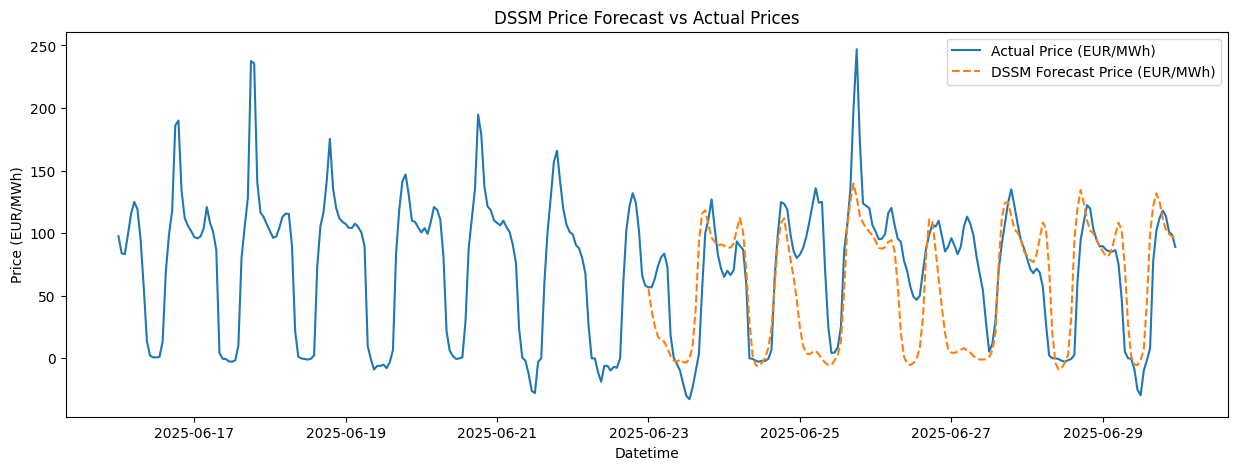

In [101]:
import sys
import pandas as pd
sys.path.append("../src")

from data.fetch_prices import get_energy_prices

df_prices = get_energy_prices("202506160000", "202506300000")

# plot vs predictions
plt.figure(figsize=(15, 5))
plt.plot(df_prices["datetime"], df_prices["price_EUR_MWh"], label="Actual Price (EUR/MWh)")
plt.plot(forecast_datetimes, forecast_unscaled, label="DSSM Forecast Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Forecast vs Actual Prices")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()



# Evaluation

In [152]:
class DSSM(nn.Module):
    def __init__(self, input_dim, state_dim, hidden_dim, dropout, num_layers):
        super().__init__()
        self.rnn = nn.GRU(input_dim, state_dim, batch_first=True, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0.0)
        self.obs_model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        state_seq, _ = self.rnn(x)
        output = self.obs_model(state_seq[:, -1, :])
        return output.squeeze(-1)

## Dropout Evaluation

In [153]:
# ----- Data prep -----
sequence_length = 24
val_days = 7
val_size = val_days * 24

# Train/Val split
train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]
val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ----- Main training & forecasting loop -----
n_epochs = 30
num_layers = 2
dropouts = [0.1, 0.15, 0.2]
predictions_dict = {}
metrics_dict = {}

for dropout in dropouts:
    print(f"\n--- Training model with dropout={dropout} ---")
    model = DSSM(input_dim=X.shape[1], state_dim=64, hidden_dim=128, dropout=dropout, num_layers=num_layers)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.L1Loss()

    # Training
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0
        for x, t in train_loader:
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, t in val_loader:
            preds = model(x)
            all_preds.append(preds.numpy())
            all_targets.append(t.squeeze(-1).numpy())

    preds_flat = np.concatenate(all_preds)
    targets_flat = np.concatenate(all_targets)

    preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()
    targets_inverse = scaler_y.inverse_transform(targets_flat.reshape(-1, 1)).flatten()

    predictions_dict[dropout] = preds_inverse

    # Metrics
    mse = mean_squared_error(targets_inverse, preds_inverse)
    mae = mean_absolute_error(targets_inverse, preds_inverse)
    denom = (np.abs(targets_inverse) + np.abs(preds_inverse)) / 2
    non_zero_mask = denom != 0
    smape = np.mean(np.abs(targets_inverse - preds_inverse)[non_zero_mask] / denom[non_zero_mask]) * 100

    threshold = np.std(actuals_inverse)
    threshold_accuracy = np.mean(np.abs(targets_inverse - preds_inverse) < threshold) * 100

    metrics_dict[dropout] = {
        "MSE": round(mse, 2),
        "MAE": round(mae, 2),
        "SMAPE": round(smape, 2),
        "Threshold Accuracy": round(threshold_accuracy, 2)
    }


--- Training model with dropout=0.1 ---
Epoch 1/30, Loss: 0.3728
Epoch 2/30, Loss: 0.3190
Epoch 3/30, Loss: 0.2356
Epoch 4/30, Loss: 0.2268
Epoch 5/30, Loss: 0.2034
Epoch 6/30, Loss: 0.1901
Epoch 7/30, Loss: 0.1954
Epoch 8/30, Loss: 0.1811
Epoch 9/30, Loss: 0.1855
Epoch 10/30, Loss: 0.1800
Epoch 11/30, Loss: 0.1796
Epoch 12/30, Loss: 0.1656
Epoch 13/30, Loss: 0.1786
Epoch 14/30, Loss: 0.1646
Epoch 15/30, Loss: 0.1973
Epoch 16/30, Loss: 0.1629
Epoch 17/30, Loss: 0.2002
Epoch 18/30, Loss: 0.1727
Epoch 19/30, Loss: 0.1793
Epoch 20/30, Loss: 0.1723
Epoch 21/30, Loss: 0.1579
Epoch 22/30, Loss: 0.1644
Epoch 23/30, Loss: 0.1563
Epoch 24/30, Loss: 0.1614
Epoch 25/30, Loss: 0.1561
Epoch 26/30, Loss: 0.1577
Epoch 27/30, Loss: 0.1528
Epoch 28/30, Loss: 0.1575
Epoch 29/30, Loss: 0.1494
Epoch 30/30, Loss: 0.1743

--- Training model with dropout=0.15 ---
Epoch 1/30, Loss: 0.3440
Epoch 2/30, Loss: 0.2893
Epoch 3/30, Loss: 0.2284
Epoch 4/30, Loss: 0.2288
Epoch 5/30, Loss: 0.2028
Epoch 6/30, Loss: 0.1

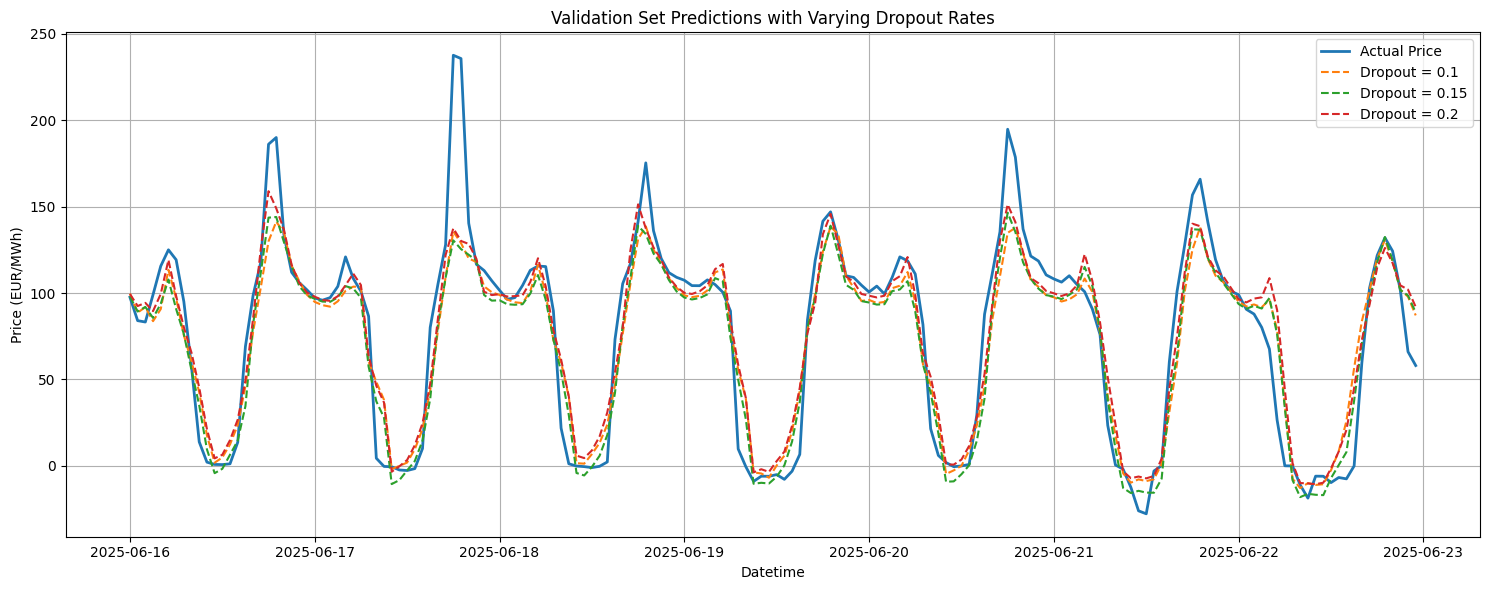

In [154]:
# Plot predictions for each dropout on validation set
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 6))
plt.plot(val_datetimes, df["price_EUR_MWh"].iloc[-val_size:], label="Actual Price", linewidth=2)

for dropout, preds in predictions_dict.items():
    plt.plot(val_datetimes, preds, label=f"Dropout = {dropout}", linestyle="--")

plt.title("Validation Set Predictions with Varying Dropout Rates")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [155]:
print("\n=== Validation Metrics per Dropout Rate ===")
for dropout, metrics in metrics_dict.items():
    print(f"\nDropout = {dropout}")
    print(f"  MSE   : {metrics['MSE']}")
    print(f"  MAE   : {metrics['MAE']}")
    print(f"  SMAPE : {metrics['SMAPE']}%")
    print(f"  Threshold Accuracy: {metrics['Threshold Accuracy']}%")


=== Validation Metrics per Dropout Rate ===

Dropout = 0.1
  MSE   : 512.66
  MAE   : 15.48
  SMAPE : 54.25%
  Threshold Accuracy: 96.43%

Dropout = 0.15
  MSE   : 453.18
  MAE   : 14.56
  SMAPE : 50.61000061035156%
  Threshold Accuracy: 98.81%

Dropout = 0.2
  MSE   : 455.67
  MAE   : 14.34
  SMAPE : 54.04999923706055%
  Threshold Accuracy: 98.21%


## Number of GRU Layers Evaluation

In [163]:
# ----- Data prep -----
sequence_length = 24
val_days = 7
val_size = val_days * 24

# Train/Val split
train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]
val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ----- Main training & forecasting loop -----
n_epochs = 30
num_layers = [1, 2, 3]
dropout = 0.15
predictions_dict = {}
metrics_dict = {}

for num_layer in num_layers:
    print(f"\n--- Training model with num_layer={num_layer} ---")
    model = DSSM(input_dim=X.shape[1], state_dim=64, hidden_dim=128, dropout=dropout, num_layers=num_layer)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.L1Loss()

    # Training
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0
        for x, t in train_loader:
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, t in val_loader:
            preds = model(x)
            all_preds.append(preds.numpy())
            all_targets.append(t.squeeze(-1).numpy())

    preds_flat = np.concatenate(all_preds)
    targets_flat = np.concatenate(all_targets)

    preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()
    targets_inverse = scaler_y.inverse_transform(targets_flat.reshape(-1, 1)).flatten()

    predictions_dict[num_layer] = preds_inverse

    # Metrics
    mse = mean_squared_error(targets_inverse, preds_inverse)
    mae = mean_absolute_error(targets_inverse, preds_inverse)
    denom = (np.abs(targets_inverse) + np.abs(preds_inverse)) / 2
    non_zero_mask = denom != 0
    smape = np.mean(np.abs(targets_inverse - preds_inverse)[non_zero_mask] / denom[non_zero_mask]) * 100

    threshold = np.std(actuals_inverse)
    threshold_accuracy = np.mean(np.abs(targets_inverse - preds_inverse) < threshold) * 100

    metrics_dict[num_layer] = {
        "MSE": round(mse, 2),
        "MAE": round(mae, 2),
        "SMAPE": round(smape, 2),
        "Threshold Accuracy": round(threshold_accuracy, 2)
    }


--- Training model with num_layer=1 ---
Epoch 1/30, Loss: 0.3373
Epoch 2/30, Loss: 0.2529
Epoch 3/30, Loss: 0.1979
Epoch 4/30, Loss: 0.1973
Epoch 5/30, Loss: 0.1750
Epoch 6/30, Loss: 0.1728
Epoch 7/30, Loss: 0.1743
Epoch 8/30, Loss: 0.1659
Epoch 9/30, Loss: 0.1685
Epoch 10/30, Loss: 0.1626
Epoch 11/30, Loss: 0.1662
Epoch 12/30, Loss: 0.1596
Epoch 13/30, Loss: 0.1672
Epoch 14/30, Loss: 0.1565
Epoch 15/30, Loss: 0.1725
Epoch 16/30, Loss: 0.1553
Epoch 17/30, Loss: 0.1720
Epoch 18/30, Loss: 0.1550
Epoch 19/30, Loss: 0.1574
Epoch 20/30, Loss: 0.1603
Epoch 21/30, Loss: 0.1507
Epoch 22/30, Loss: 0.1573
Epoch 23/30, Loss: 0.1478
Epoch 24/30, Loss: 0.1513
Epoch 25/30, Loss: 0.1466
Epoch 26/30, Loss: 0.1495
Epoch 27/30, Loss: 0.1448
Epoch 28/30, Loss: 0.1498
Epoch 29/30, Loss: 0.1419
Epoch 30/30, Loss: 0.1645

--- Training model with num_layer=2 ---
Epoch 1/30, Loss: 0.3686
Epoch 2/30, Loss: 0.3407
Epoch 3/30, Loss: 0.2512
Epoch 4/30, Loss: 0.2411
Epoch 5/30, Loss: 0.2125
Epoch 6/30, Loss: 0.19

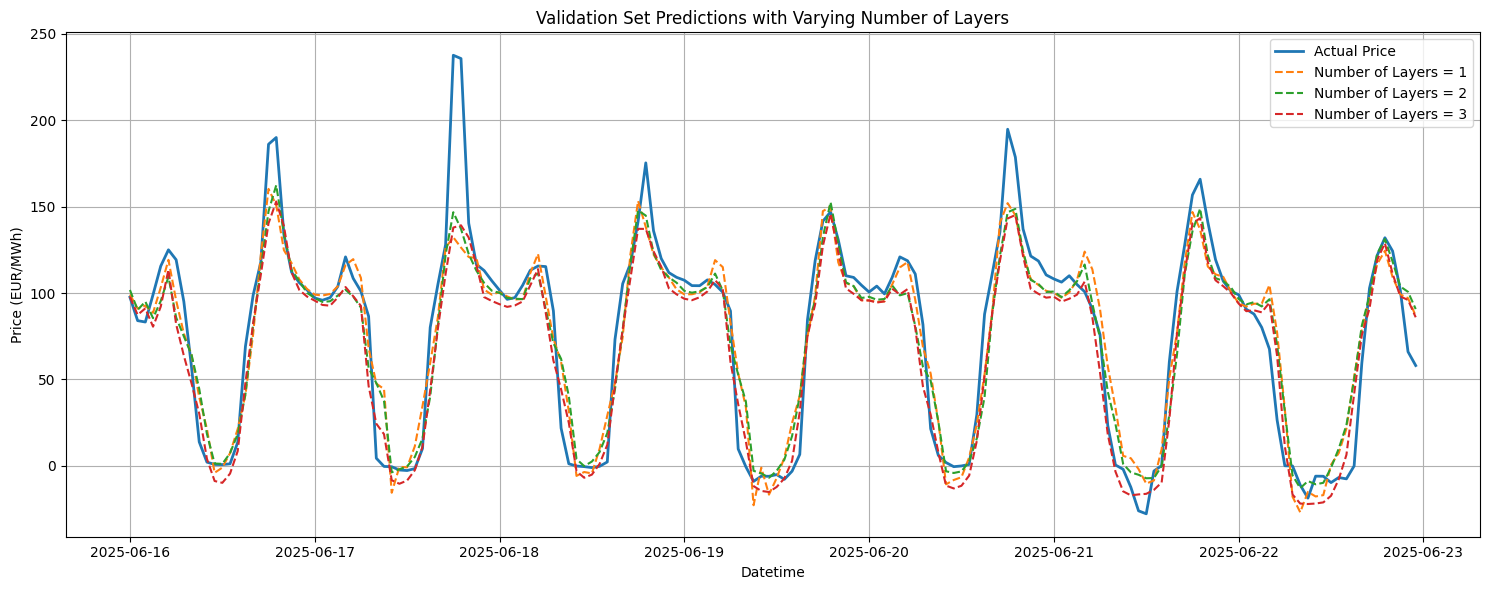

In [157]:
# Plot predictions for each num_layer on validation set
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 6))
plt.plot(val_datetimes, df["price_EUR_MWh"].iloc[-val_size:], label="Actual Price", linewidth=2)

for num_layer, preds in predictions_dict.items():
    plt.plot(val_datetimes, preds, label=f"Number of Layers = {num_layer}", linestyle="--")

plt.title("Validation Set Predictions with Varying Number of Layers")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [164]:
print("\n=== Validation Metrics per Number of Layers ===")
for num_layer, metrics in metrics_dict.items():
    print(f"\nNumber of Layers = {num_layer}")
    print(f"  MSE   : {metrics['MSE']}")
    print(f"  MAE   : {metrics['MAE']}")
    print(f"  SMAPE : {metrics['SMAPE']}%")
    print(f"  Threshold Accuracy: {metrics['Threshold Accuracy']}%")


=== Validation Metrics per Number of Layers ===

Number of Layers = 1
  MSE   : 479.15
  MAE   : 15.45
  SMAPE : 53.459999084472656%
  Threshold Accuracy: 97.62%

Number of Layers = 2
  MSE   : 404.59
  MAE   : 14.02
  SMAPE : 51.65999984741211%
  Threshold Accuracy: 98.81%

Number of Layers = 3
  MSE   : 386.94
  MAE   : 12.77
  SMAPE : 44.959999084472656%
  Threshold Accuracy: 98.21%


## Sequence Length Evaluation

In [165]:
sequence_lengths = [24, 72, 168]
val_days = 7
val_size = val_days * 24

n_epochs = 30
dropout = 0.15
num_layers = 2  # fixed
predictions_dict = {}
metrics_dict = {}

# For consistent validation targets
val_targets = y[-val_size:]
val_targets_inverse = scaler_y.inverse_transform(val_targets.reshape(-1, 1)).flatten()

for seq_len in sequence_lengths:
    print(f"\n--- Training model with sequence_length={seq_len} ---")

    # Prepare train/val split for this sequence length
    train_X = X[:-val_size]
    train_y = y[:-val_size]
    val_X = X[-val_size - seq_len:]
    val_y = y[-val_size - seq_len:]

    train_dataset = TimeSeriesDataset(train_X, train_y, seq_len)
    val_dataset = TimeSeriesDataset(val_X, val_y, seq_len)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize model
    model = DSSM(input_dim=X.shape[1], state_dim=64, hidden_dim=128, dropout=dropout, num_layers=num_layers)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.L1Loss()

    # Training loop
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0
        for x, t in train_loader:
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Validation prediction
    model.eval()
    all_preds = []
    with torch.no_grad():
        for x, _ in val_loader:
            preds = model(x)
            all_preds.append(preds.numpy())

    preds_flat = np.concatenate(all_preds)
    preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()

    # Align predictions to last val_size points
    aligned_preds = preds_inverse[-val_size:]
    predictions_dict[seq_len] = aligned_preds

    # Metrics
    mse = mean_squared_error(val_targets_inverse, aligned_preds)
    mae = mean_absolute_error(val_targets_inverse, aligned_preds)
    denom = (np.abs(val_targets_inverse) + np.abs(aligned_preds)) / 2
    non_zero_mask = denom != 0
    smape = np.mean(np.abs(val_targets_inverse - aligned_preds)[non_zero_mask] / denom[non_zero_mask]) * 100

    threshold = np.std(actuals_inverse)
    threshold_accuracy = np.mean(np.abs(targets_inverse - preds_inverse) < threshold) * 100

    metrics_dict[seq_len] = {
        "MSE": round(mse, 2),
        "MAE": round(mae, 2),
        "SMAPE": round(smape, 2),
        "Threshold Accuracy": round(threshold_accuracy, 2)
    }


--- Training model with sequence_length=24 ---
Epoch 1/30, Loss: 0.3596
Epoch 2/30, Loss: 0.3143
Epoch 3/30, Loss: 0.2481
Epoch 4/30, Loss: 0.2388
Epoch 5/30, Loss: 0.2082
Epoch 6/30, Loss: 0.1945
Epoch 7/30, Loss: 0.2017
Epoch 8/30, Loss: 0.1854
Epoch 9/30, Loss: 0.1922
Epoch 10/30, Loss: 0.1795
Epoch 11/30, Loss: 0.1853
Epoch 12/30, Loss: 0.1704
Epoch 13/30, Loss: 0.1845
Epoch 14/30, Loss: 0.1667
Epoch 15/30, Loss: 0.1994
Epoch 16/30, Loss: 0.1671
Epoch 17/30, Loss: 0.2025
Epoch 18/30, Loss: 0.1771
Epoch 19/30, Loss: 0.1805
Epoch 20/30, Loss: 0.1771
Epoch 21/30, Loss: 0.1631
Epoch 22/30, Loss: 0.1681
Epoch 23/30, Loss: 0.1602
Epoch 24/30, Loss: 0.1639
Epoch 25/30, Loss: 0.1571
Epoch 26/30, Loss: 0.1635
Epoch 27/30, Loss: 0.1541
Epoch 28/30, Loss: 0.1624
Epoch 29/30, Loss: 0.1541
Epoch 30/30, Loss: 0.1748

--- Training model with sequence_length=72 ---
Epoch 1/30, Loss: 0.3624
Epoch 2/30, Loss: 0.3132
Epoch 3/30, Loss: 0.2499
Epoch 4/30, Loss: 0.2273
Epoch 5/30, Loss: 0.2086
Epoch 6/

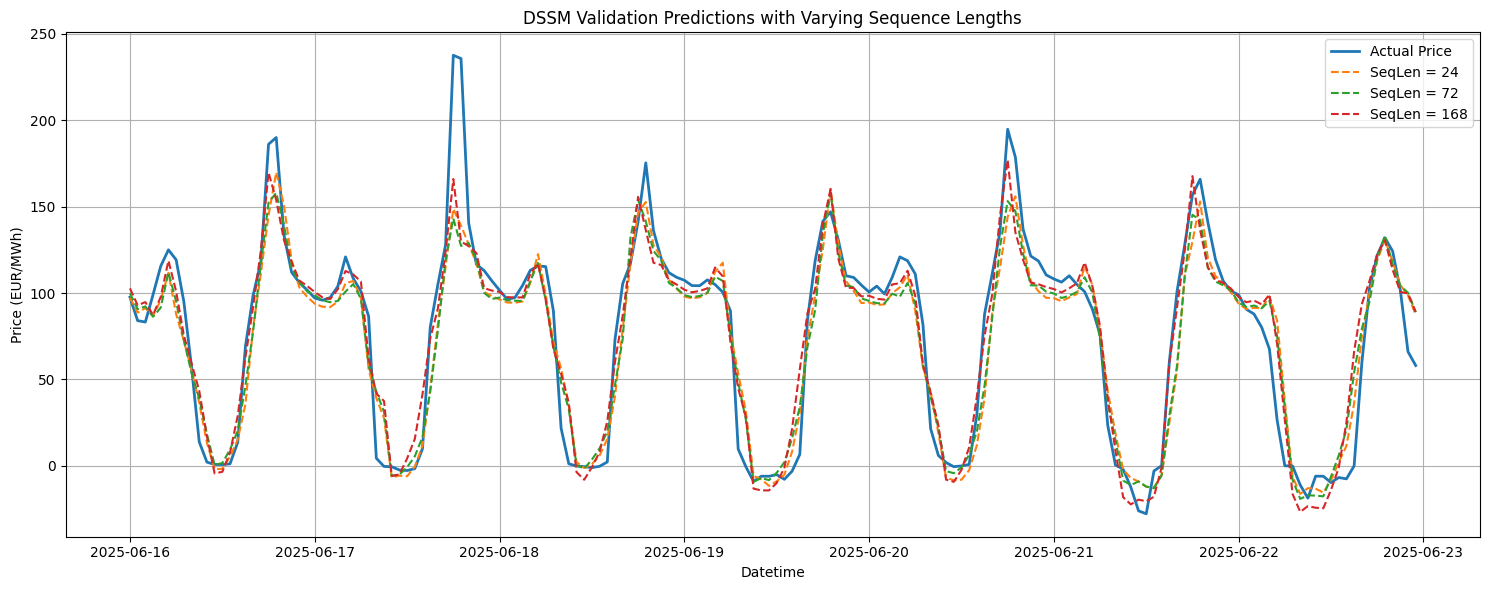

In [168]:
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 6))
plt.plot(val_datetimes, val_targets_inverse, label="Actual Price", linewidth=2)

for seq_len, preds in predictions_dict.items():
    plt.plot(val_datetimes, preds, label=f"SeqLen = {seq_len}", linestyle="--")

plt.title("DSSM Validation Predictions with Varying Sequence Lengths")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [170]:
print("\n=== Validation Metrics by Sequence Length ===")
for seq_len, metrics in metrics_dict.items():
    print(f"\nSequence Length = {seq_len}")
    print(f"  MSE   : {metrics['MSE']}")
    print(f"  MAE   : {metrics['MAE']}")
    print(f"  SMAPE : {metrics['SMAPE']}%")
    print(f"  Threshold Accuracy: {metrics['Threshold Accuracy']}%")


=== Validation Metrics by Sequence Length ===

Sequence Length = 24
  MSE   : 408.84
  MAE   : 14.13
  SMAPE : 50.38%
  Threshold Accuracy: 98.21%

Sequence Length = 72
  MSE   : 425.82
  MAE   : 14.26
  SMAPE : 49.99%
  Threshold Accuracy: 98.21%

Sequence Length = 168
  MSE   : 372.7
  MAE   : 13.2
  SMAPE : 50.7%
  Threshold Accuracy: 98.21%
